[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Rogers_1975/fig_1.ipynb)   
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=examples/PySDM_examples/Rogers_1975/fig_1.ipynb)   
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Rogers_1975/fig_1.ipynb)

basic parcel simulation based on [Rogers 1975](https://doi.org/10.1080/00046973.1975.9648397) implemented using SciPy+Pint but without PySDM - for illustrative purposes.

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [2]:
import collections
import functools
from open_atmos_jupyter_utils import show_plot
from matplotlib import pyplot
import numpy as np
import scipy
from scipy import constants
import chempy

In [3]:
import pint
si = pint.UnitRegistry()
si.setup_matplotlib()
si.define('fraction = [] = frac')
si.define('percent = 1e-2 frac = pct')

In [4]:
class Storage:
    """ state vector representation with each element having its own Pint-compatible
    physical dimension, thus allowing to seamlessly couple Pint and scipy.odeint
    (all methods return objects that inherit from `numpy.ndarray` but are additionally
    equipped with .VAR unit-aware setters and getters, allowing both unit-unaware
    whole-array expressions (e.g., `state += dt * deriv`) as well as unit-aware 
    operations on state vars (e.g., `state.T = 300 * si.K` or `state.m[:] = ...`) """

    var_units = {
        'p': si.Pa,
        'T': si.K,
        'S': si.dimensionless,
        'r': si.metre,
    }
    
    der_unit = si.second

    @staticmethod
    def __make_storage(shape, deriv=False):
        def getter(self, idx, unit):
            return self[idx] * unit

        def setter(self, value, idx, unit):
            self[idx] = (value.to(unit) / unit).magnitude

        properties = {}
        for i, key in enumerate(Storage.var_units.keys()):
            kwargs = {
                'unit': Storage.var_units[key] / (Storage.der_unit if deriv else 1),
                'idx': i
            }
            properties[key] = property(
                functools.partial(getter, **kwargs),
                functools.partial(setter, **kwargs),
            ) 
        
        return type("StorageImpl", (np.ndarray,), properties)(shape)

    @staticmethod
    def make_state():
        """ returns a newly allocated unit-aware storage """
        return Storage.__make_storage((len(Storage.var_units),))

    @staticmethod
    def make_deriv(state):
        """ returns a newly allocated unit-aware storage with size of `state` and derivative dimensions """
        return Storage.__make_storage(state.shape, deriv=True)

    @staticmethod
    def view_state(array):
        """ returns a newly allocated unit-aware storage with size and data from unit-unaware `array` """
        storage = Storage.__make_storage(array.shape)
        storage[:] = array[:]
        return storage

In [5]:
# constants (coefficients with modified 10 exponents to match SI units)
C = {
    # gas constant for dry air
    "R": scipy.constants.R * si.joule / si.kelvin / si.mole / (
        0.76 * chempy.Substance.from_formula("N2").mass * si.gram / si.mole
        + 0.23 * chempy.Substance.from_formula("O2").mass * si.gram / si.mole
        + 0.01 * chempy.Substance.from_formula("Ar").mass * si.gram / si.mole
    ),
    # standard acceleration of gravity
    "g": scipy.constants.g * si.metre / si.second**2,
    # latent heat of condensation
    "L": 2.5e3 * si.J / si.g,
    # specific gravity of vapour vs. dry air
    "eps": .622,
    # specific heat at constant pressure of dry air
    "cp": 1005 * si.joule / si.kilogram / si.kelvin,
    # density of liquid water
    "rho_L": 1 * si.kg / si.litre,
    # eq A.1
    "K": lambda T: 2.42e-2 * (393/(T.to(si.K).magnitude + 120)) * (T.to(si.K).magnitude/273)**(3/2) * si.J / si.m / si.s / si.K,
    # eq A.2
    "D_over_K": lambda p, T: 8.28 * T.to(si.K).magnitude / p.to(si.dyne / si.cm**2).magnitude * si.m**3 / si.J * si.K,
    # eq A.3
    "e_s": lambda T: 2.75e12 * np.exp(-5.44e3 / (T/si.K)) * si.ubar,
}
C = collections.namedtuple("C", C.keys())(**C)

In [6]:
np.testing.assert_approx_equal(actual=C.e_s(273.15 * si.K).to(si.mbar).magnitude, desired=6.1, significant=2)
np.testing.assert_approx_equal(actual=C.K(273.15 * si.K).to(si.J / si.m / si.s / si.K).magnitude, desired=2.4e-2, significant=2)
np.testing.assert_approx_equal(
    actual=(C.K(169.75 * si.K) * C.D_over_K(1000 * si.hPa, 169.75 * si.K)).to(si.m**2 / si.s).magnitude,
    desired=2.26e-5,
    significant=2
)

In [7]:
# ODE system
class System:
    def __init__(self, *, U, nu_0):
        self.U = U
        self.nu_0 = nu_0

    def __call__(self, _, state):
        state = Storage.view_state(state)
        deriv = Storage.make_deriv(state)

        # eq (8)
        rho = state.p / C.R / state.T
        
        # eq (5) multiplied by Δt
        deriv.p = -rho * C.g * self.U 

        # eq (2)
        K = C.K(state.T)
        Fk = C.L**2 * C.eps * C.rho_L / K / C.R / state.T**2
        Fd = C.R * state.T * C.rho_L / C.eps / C.D_over_K(state.p, state.T) / K / C.e_s(state.T)
        sigma = (state.S - 1) / (Fk + Fd)
        
        # eq (1)
        deriv.r = sigma / state.r
        
        # time derivative of eq (4)
        dksi_dt = 4 * np.pi * C.rho_L * self.nu_0 * state.r**2 * deriv.r
        
        # eq (6) divided by dt, multiplied by T
        deriv.T = (
            state.T * C.R / C.cp * deriv.p / state.p + 
            C.L / C.cp * dksi_dt
        )

        # eq (10)
        Q1 = C.L * C.g * C.eps / C.R / C.cp / state.T**2 - C.g / C.R / state.T
        Q2 = C.R * state.T / C.eps / C.e_s(state.T) + C.eps * C.L**2 / C.cp / state.T / state.p
        deriv.S = Q1 * self.U - rho * Q2 * dksi_dt
        
        return deriv

In [8]:
def solve(system, state, t_max, max_step):
    integ = scipy.integrate.solve_ivp(
        system,
        [0, t_max / Storage.der_unit],
        state,
        max_step=max_step.to(Storage.der_unit).magnitude,
        method='LSODA'
    )
    assert integ.success, integ.message
    return Storage.view_state(integ.y), integ.t * Storage.der_unit

In [9]:
state = Storage.make_state()
state.p = 800 * si.mbar
state.T = (273.15 + 7) * si.K
state.S = 1 * si.dimensionless
state.r = 8 * si.um

rho0 = state.p / C.R / state.T
system = System(U=10 * si.m / si.s, nu_0=200 / si.cm**3 / rho0)
solution, tsteps = solve(system, state, t_max=20 * si.s, max_step=.5 * si.s)

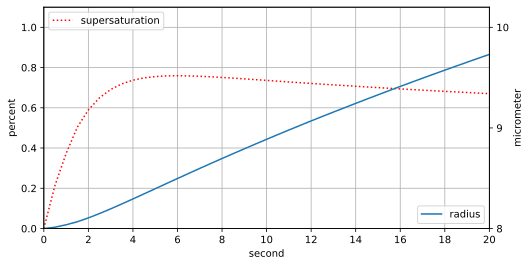

In [10]:
fig, ax = pyplot.subplots(1, 1, figsize=(8, 4))

ax.plot(tsteps, solution.S-1, label='supersaturation', color='red', linestyle=':')
ax.yaxis.set_units(si.percent)

tx = ax.twinx()
tx.plot(tsteps, solution.r, label='radius')
tx.yaxis.set_units(si.um)

ax.legend(loc='upper left')
tx.legend(loc='lower right')
ax.grid()

ax.set_xticks(range(0, 21, 2))
ax.set_xlim(tsteps[0], tsteps[-1])
ax.set_ylim(0, 1.1)
tx.set_ylim(8, 10.2)
tx.set_yticks(range(8, 11))

show_plot('fig_1')